In [1]:
import torch
from transformers import AutoModel, AutoTokenizer
import tqdm
from collections import defaultdict
from model_helper import l2_get_evaluation_set, two_gram_overlap, l2_DOCUMENT, l2_QUERY
import matplotlib.pyplot as plt

df = l2_get_evaluation_set()

/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# !git -C ColBERT/ pull || git clone https://github.com/stanford-futuredata/ColBERT.git
# import sys; sys.path.insert(0, 'ColBERT/')

# this is another approach to git pull ColBERT from git; but we are instead going with pip install 

In [2]:
import colbert
from colbert import Indexer, Searcher
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries, Collection

In [4]:
checkpoint = 'colbert-ir/colbertv2.0'
nbits = 2   # encode each dimension with 2 bits
doc_maxlen = 300 # truncate passages at 300 tokens
max_id = 4000

index_name = f'{nbits}bits'
collection = df[l2_DOCUMENT].to_list()
queries = df[l2_QUERY].to_list()

In [5]:
checkpoint = 'colbert-ir/colbertv2.0'

with Run().context(RunConfig(nranks=1, experiment='notebook')):  # nranks specifies the number of GPUs to use
    config = ColBERTConfig(doc_maxlen=doc_maxlen, nbits=nbits, kmeans_niters=4) # kmeans_niters specifies the number of iterations of k-means clustering; 4 is a good and fast default.
                                                                                # Consider larger numbers for small datasets.

    indexer = Indexer(checkpoint=checkpoint, config=config)
    indexer.index(name=index_name, collection=collection[:max_id], overwrite=True)



[Mar 12, 15:28:20] #> Note: Output directory /Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits already exists


[Mar 12, 15:28:20] #> Will delete 10 files already at /Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits in 20 seconds...
#> Starting...
{
    "query_token_id": "[unused0]",
    "doc_token_id": "[unused1]",
    "query_token": "[Q]",
    "doc_token": "[D]",
    "ncells": null,
    "centroid_score_threshold": null,
    "ndocs": null,
    "load_index_with_mmap": false,
    "index_path": null,
    "index_bsize": 64,
    "nbits": 2,
    "kmeans_niters": 4,
    "resume": false,
    "similarity": "cosine",
    "bsize": 64,
    "accumsteps": 1,
    "lr": 1e-5,
    "maxsteps": 400000,
    "save_every": null,
    "warmup": 20000,
    "warmup_bert": null,
    "relu": false,
    "nway": 64,
    "use_ib_negatives": true,
    "reranker": false,
    "distillation_alpha": 1.0,
    "ignore_scores": false,
    "model_name": null,
    "quer

/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


[Mar 12, 15:28:42] [0] 		 # of sampled PIDs = 4000 	 sampled_pids[:3] = [1706, 3001, 41]
[Mar 12, 15:28:42] [0] 		 #> Encoding 4000 passages..


  0%|          | 0/50 [00:00<?, ?it/s]/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  2%|▏         | 1/50 [00:05<04:28,  5.48s/it]/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 13/13 [00:57<00:00,  4.39s/it]


[Mar 12, 15:33:37] [0] 		 avg_doclen_est = 244.5712432861328 	 len(local_sample) = 4,000
[Mar 12, 15:33:37] [0] 		 Creating 8,192 partitions.
[Mar 12, 15:33:37] [0] 		 *Estimated* 978,284 embeddings.
[Mar 12, 15:33:37] [0] 		 #> Saving the indexing plan to /Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits/plan.json ..
Clustering 929371 points in 128D to 8192 clusters, redo 1 times, 4 iterations
  Preprocessing in 0.04 s
  Iteration 3 (20.18 s, search 20.09 s): objective=246981 imbalance=1.363 nsplit=0       
[0.038, 0.039, 0.04, 0.035, 0.038, 0.036, 0.035, 0.035, 0.036, 0.039, 0.035, 0.037, 0.036, 0.038, 0.037, 0.04, 0.034, 0.037, 0.036, 0.035, 0.036, 0.037, 0.037, 0.036, 0.037, 0.034, 0.036, 0.036, 0.038, 0.037, 0.036, 0.038, 0.04, 0.036, 0.035, 0.035, 0.034, 0.036, 0.037, 0.043, 0.04, 0.036, 0.036, 0.036, 0.039, 0.035, 0.034, 0.041, 0.039, 0.035, 0.036, 0.037, 0.036, 0.037, 0.035, 0.037, 0.04, 0.038, 0.044, 0.035, 0.035, 0.038, 0.037, 0.039, 0.039, 0.039, 0

0it [00:00, ?it/s]
100%|██████████| 50/50 [04:07<00:00,  4.95s/it]

100%|██████████| 13/13 [00:56<00:00,  4.31s/it]


[Mar 12, 15:39:09] [0] 		 #> Saving chunk 0: 	 4,000 passages and 978,285 embeddings. From #0 onward.


1it [05:22, 322.46s/it]
100%|██████████| 8192/8192 [00:00<00:00, 114727.50it/s]


[Mar 12, 15:39:22] [0] 		 #> Checking all files were saved...
[Mar 12, 15:39:22] [0] 		 Found all files!
[Mar 12, 15:39:22] [0] 		 #> Building IVF...
[Mar 12, 15:39:22] [0] 		 #> Loading codes...
[Mar 12, 15:39:22] [0] 		 Sorting codes...
[Mar 12, 15:39:22] [0] 		 Getting unique codes...
[Mar 12, 15:39:22] #> Optimizing IVF to store map from centroids to list of pids..
[Mar 12, 15:39:22] #> Building the emb2pid mapping..
[Mar 12, 15:39:22] len(emb2pid) = 978285
[Mar 12, 15:39:22] #> Saved optimized IVF to /Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits/ivf.pid.pt
[Mar 12, 15:39:22] [0] 		 #> Saving the indexing metadata to /Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits/metadata.json ..
#> Joined...


In [6]:
indexer.get_index() # You can get the absolute path of the index, if needed.

'/Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits'

In [7]:
with Run().context(RunConfig(experiment='notebook')):
    searcher = Searcher(index=index_name, collection=collection)

[Mar 12, 15:39:23] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Mar 12, 15:39:24] #> Loading codec...
[Mar 12, 15:39:24] #> Loading IVF...
[Mar 12, 15:39:24] Loading segmented_lookup_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


[Mar 12, 15:39:24] #> Loading doclens...


100%|██████████| 1/1 [00:00<00:00, 4219.62it/s]

[Mar 12, 15:39:24] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 97.10it/s]

[Mar 12, 15:39:24] Loading filter_pids_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


[Mar 12, 15:39:24] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


Calculating recall scores:   0%|          | 0/4000 [00:00<?, ?it/s]/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Uncle Pros, uncle of the sick woman and mainstay of the forlorn little Consadine household, stops by to borrow a hammer and nails from Jeff Dawes. A woman with a little bundle in her arm appears and asks where Laurelly put the baby's clothes. Laurelly says she went to Tarver's wife, who has plenty of baby clothes she couldn't expect to wear out on her own children. Uncle Pros lifts the baby into the cradle and says he'll give it a few licks of paint. Outside, he begins to sing at his work. Laurella Consadine, commonly called Laurella Passmore, scrambles to her feet and says she'll get along, always have. She declares an intention to come home and pay back every one to whom they are under obligations., 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  4470,  4013,  2015,  1010,  4470,  1997,  1996,  5305,
         2450,  1998,  2364,  9153,  2100,  1997,  1996,  2005, 10626,  20

Calculating recall scores:   0%|          | 1/4000 [00:00<38:11,  1.74it/s]/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Calculating recall scores: 100%|██████████| 4000/4000 [03:28<00:00, 19.15it/s]


Average Recall @k: {1: 0.9215, 2: 0.94525, 3: 0.94875, 4: 0.9525, 5: 0.95525, 6: 0.956, 7: 0.958, 8: 0.95875, 9: 0.95925, 10: 0.96075}


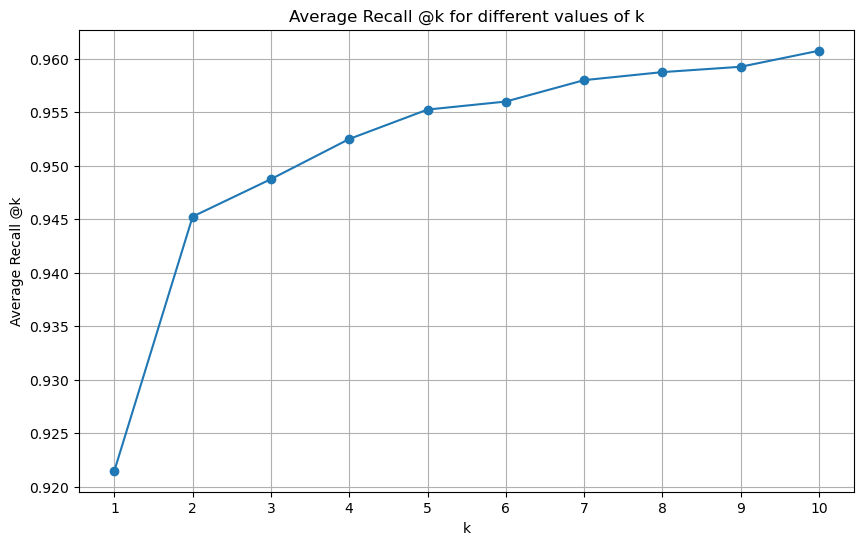

In [8]:
# Function to calculate recall @k for a single query with results pre-fetched
def calculate_recall_at_k(retrieved_docs, true_doc, k):
    recall = int(true_doc in retrieved_docs[:k])
    return recall

# Function to fetch search results once and calculate recall scores for each k
def get_recall_scores(searcher, queries, true_docs, k_range):
    recall_scores = {k: [] for k in k_range}
    for query, true_doc in tqdm.tqdm(zip(queries, true_docs), total=len(queries), desc="Calculating recall scores"):
        results = searcher.search(query, k=max(k_range))
        retrieved_docs = [searcher.collection[pid] for pid, _, _ in zip(*results)]
        for k in k_range:
            recall = calculate_recall_at_k(retrieved_docs, true_doc, k)
            recall_scores[k].append(recall)
    # Consolidate recall scores by calculating the average for each k
    average_recall_scores = {k: sum(recalls)/len(recalls) for k, recalls in recall_scores.items()}
    return average_recall_scores

# Function to plot average recall @k
def plot_average_recall_k(average_recall_scores):
    k_values = list(average_recall_scores.keys())
    recall_values = list(average_recall_scores.values())

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, recall_values, marker='o')
    plt.xlabel('k')
    plt.ylabel('Average Recall @k')
    plt.title('Average Recall @k for different values of k')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

# Main execution
k_range = range(1, 11)

# Calculate and consolidate recall scores
average_recall_scores = get_recall_scores(searcher, queries, collection, k_range)

# Print average recall scores
print("Average Recall @k:", average_recall_scores)

# Plot average recall @k
plot_average_recall_k(average_recall_scores)

In [9]:
def plot_ngram_vs_passage_score(ngram_scores, passage_scores):
    plt.figure(figsize=(10, 6))
    plt.scatter(ngram_scores, passage_scores)
    plt.xlabel('N-gram Score')
    plt.ylabel('Passage Score')
    plt.title('N-gram Score vs Passage Score')
    plt.grid(True)
    plt.show()

Calculating N-gram and passage scores:   0%|          | 0/4000 [00:00<?, ?it/s]/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Calculating N-gram and passage scores: 100%|██████████| 4000/4000 [03:38<00:00, 18.31it/s]


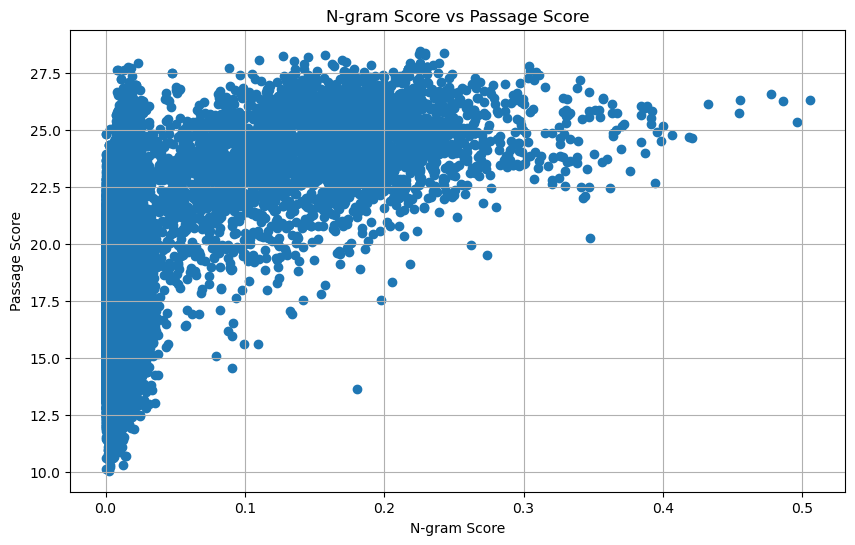

In [10]:
ngram_scores = []
passage_scores = []

for query in tqdm.tqdm(queries, desc="Calculating N-gram and passage scores"):
    results = searcher.search(query, k=10)
    for passage_id, _, passage_score in zip(*results):
        doc = searcher.collection[passage_id]
        ngram_scores.append(two_gram_overlap(query, doc))
        passage_scores.append(passage_score)

# Plot ngram score vs passage score
plot_ngram_vs_passage_score(ngram_scores, passage_scores)